**Metric: Cleanliness and Neighborhood Image**

For my metric, I chose to assess the cleanliness and overall image of neighborhoods. To achieve this, I utilized a dataset that provides a comprehensive list of violations and their corresponding addresses. My approach involves an inverse analysis—determining how "dirty" or "unclean" a neighborhood is based on the number and severity of violations recorded.

This perspective allows for a more nuanced understanding of neighborhood cleanliness by highlighting areas with higher levels of reported issues.
For my dataset I use **Pittsburgh PLI/DOMI/ES Violations Report**
You can access the dataset [here](https://data.wprdc.org/dataset/pittsburgh-pli-violations-report).


**PROBLEM**
The dataset does not list the violations by neighborhoods, but by address.
**SOLUTION**
I created a code using a Google map api to link address to the neighborhood

In [ ]:
import pandas as pd
import requests
import time


file_path = 'C:/Users/daluk/Downloads/addresses.csv'  
addresses_df = pd.read_csv(file_path)


API_KEY = 'AIDzOaSNyBTz2fjL8j1OU7OVdK6mT8QujNhaE_qH37fMc'  #Not actually the real API key

def getNeighborhood(address, api_key):
    #Finding what address belongs to which neighborhood using the Google Geocoding API.
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    params = {'address': address,'key': api_key}
    response = requests.get(base_url, params=params)
    # HTTP request is good to go
    if response.status_code == 200:
        data = response.json()
        if 'results' in data and len(data['results']) > 0:
            #Grabs the first result
            for component in data['results'][0]['address_components']:
                if 'neighborhood' in component['types']:
                    return component['long_name']
        return "Neighborhood not found" # in case the code doesn't find a neighborhood; happened a couple times
    else:
        return f"Error: {response.status_code}" # error handling

#store neighborhoods
neighborhoods = []

#for loop that iterates through the 190k+ addresses 
for address in addresses_df['address']:
    try:
        neighborhood = getNeighborhood(address, API_KEY)
        neighborhoods.append(neighborhood)
        print(f"Processed: {address} -> {neighborhood}") # Outpots to the console so I could keep track of what address had been processed
        time.sleep(0.2)  # So google doesn't get angry (so it doesn't trigger rate limites)
    except Exception as e:
        neighborhoods.append(f"Error: {e}")
        print(f"Error processing address {address}: {e}")


addresses_df['neighborhood'] = neighborhoods


output_file_path = 'Chukwudalu_addresses_with_neighborhoods_full.csv'
addresses_df.to_csv(output_file_path, index=False) # I didn't need the row numbers so I put index false

print(f"AMAZING NEWS!!!! \n Process is done. All addresses have been ouputed to: {output_file_path}")


**VIOLATIONS CODE** 
This code counts the violations per neighborhood and visualizes them


Top 5 neighborhoods with the most violations:
           neighborhood  violation_count  cleanliness_score
76     South Side Flats             9157           0.000000
15              Carrick             6699           2.687808
77    South Side Slopes             6399           3.015856
81  Squirrel Hill South             5685           3.796610
56     Mount Washington             5105           4.430837

Top 5 neighborhoods with the least violations:
            neighborhood  violation_count  cleanliness_score
90  Washington'S Landing               12          10.000000
37            Glen Hazel               24           9.986878
5      Arlington Heights               24           9.986878
0              Allegheny               39           9.970476
24           Duck Hollow               39           9.970476

Cleanliness scores for all neighborhoods saved to: C:/Users/daluk/neighborhood_cleanliness_scores.csv


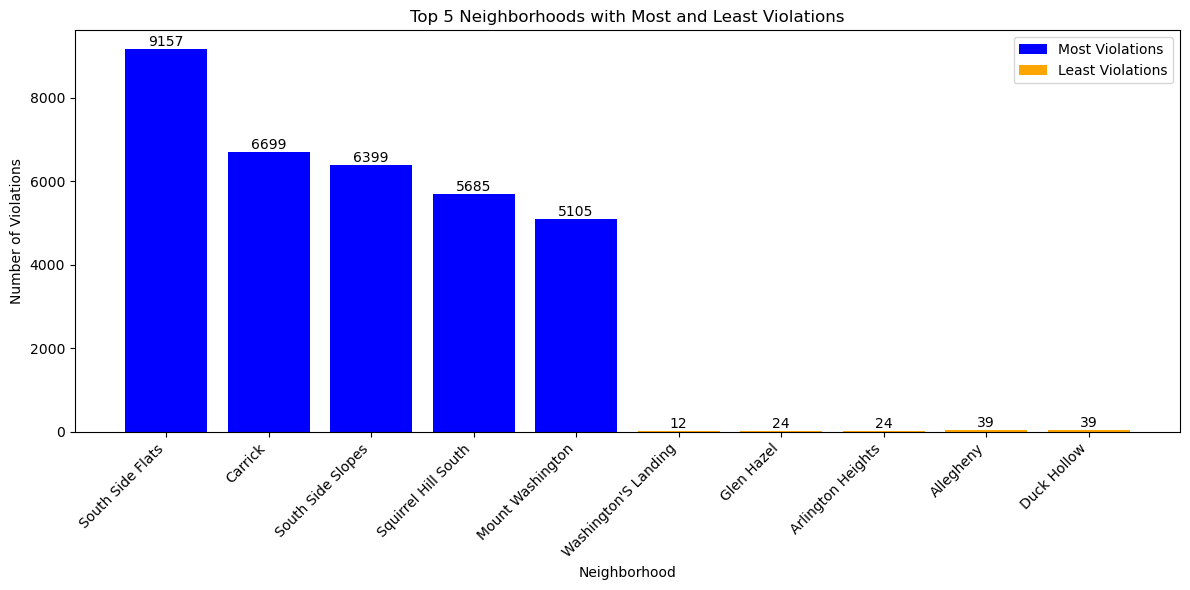

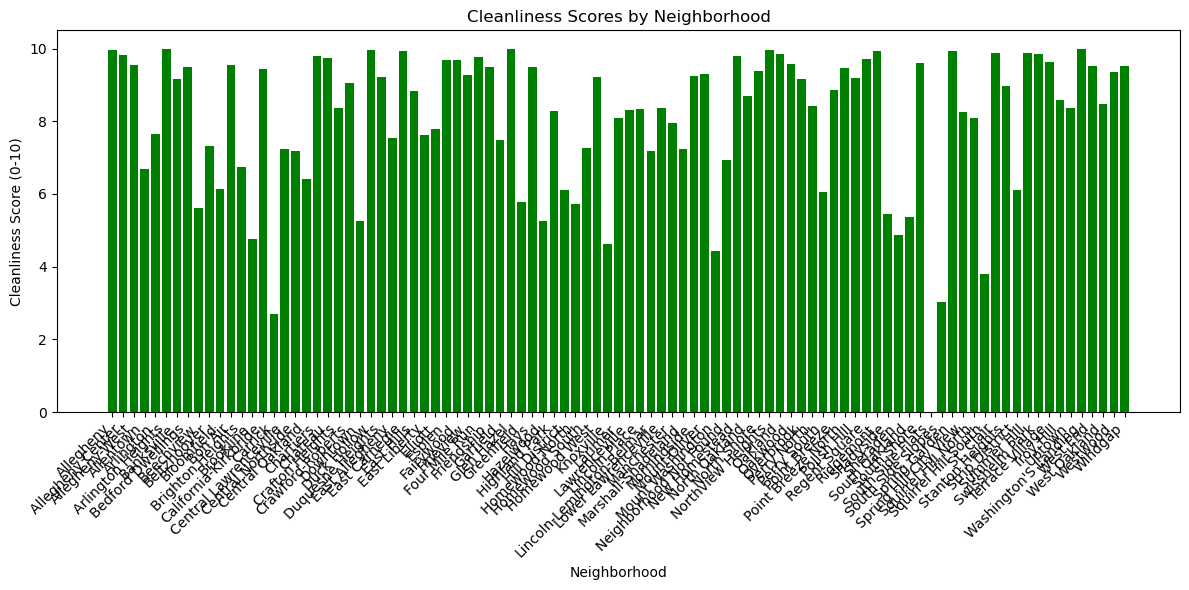

bob


In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
violations_data = pd.read_csv("C:/Users/daluk/Chukwudalu_addresses_with_neighborhoods_full.csv")

# Clean and normalize the neighborhood names
violations_data['neighborhood'] = violations_data['neighborhood'].str.strip().str.title()

# Group data by neighborhood and count violations
violations_count = violations_data.groupby('neighborhood').size().reset_index(name='violation_count')

# Normalize the violations to create a cleanliness score (higher score for fewer violations)
violations_count['cleanliness_score'] = (violations_count['violation_count'].max() - violations_count['violation_count']) / \
                                        (violations_count['violation_count'].max() - violations_count['violation_count'].min()) * 10

# Sorting neighborhoods by the number of violations for most and least violations
top_violations = violations_count.sort_values(by='violation_count', ascending=False).head(5)
lowest_violations = violations_count.sort_values(by='violation_count', ascending=True).head(5)

# Print the results for the top and lowest violations
print("Top 5 neighborhoods with the most violations:")
print(top_violations[['neighborhood', 'violation_count', 'cleanliness_score']])
print("\nTop 5 neighborhoods with the least violations:")
print(lowest_violations[['neighborhood', 'violation_count', 'cleanliness_score']])

# Save all neighborhood points to a CSV file
output_file_path = "C:/Users/daluk/neighborhood_cleanliness_scores.csv"
violations_count.to_csv(output_file_path, index=False)
print(f"\nCleanliness scores for all neighborhoods saved to: {output_file_path}")

# Visualization for top and least violations
plt.figure(figsize=(12, 6))
plt.bar(top_violations['neighborhood'], top_violations['violation_count'], label='Most Violations', color='blue')
plt.bar(lowest_violations['neighborhood'], lowest_violations['violation_count'], label='Least Violations', color='orange')

for i, row in top_violations.iterrows():
    plt.text(x=row['neighborhood'], y=row['violation_count'], s=f"{row['violation_count']}", 
             ha='center', va='bottom', fontsize=10)

for i, row in lowest_violations.iterrows():
    plt.text(x=row['neighborhood'], y=row['violation_count'], s=f"{row['violation_count']}", 
             ha='center', va='bottom', fontsize=10)

plt.xlabel('Neighborhood')
plt.ylabel('Number of Violations')
plt.title('Top 5 Neighborhoods with Most and Least Violations')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# Visualization for cleanliness scores of all neighborhoods
plt.figure(figsize=(12, 6))
plt.bar(violations_count['neighborhood'], violations_count['cleanliness_score'], color='green')
plt.xlabel('Neighborhood')
plt.ylabel('Cleanliness Score (0-10)')
plt.title('Cleanliness Scores by Neighborhood')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
print("bob")